In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import yaml
import pickle
import networkx as nx
from sentence_transformers import SentenceTransformer
from statistics import mean, stdev, median
from gnd_graph import GNDGraph
from gnd_dataset import GNDDataset
from numpy import histogram
import random
from evaluate_results.genres import add_hsg_info, hsg_data

In [3]:
plot_dir = "../figures"

In [4]:
data_path = "../dataset"
gnd_path = "../gnd/gnd.pickle"
gnd = pickle.load(open(gnd_path, "rb"))
gnd = GNDGraph(gnd)

data = GNDDataset(
    data_dir=data_path,
    gnd_graph=gnd,
    load_from_disk=True,
)

In [5]:
df_train = data["train"].to_pandas()
df_train.sample(5)

,title,label-ids,label-names,doc_idn
527624,Geistbeck Alois,[041890523],[Wandbild],365936146
275253,Pädagogik,[040443027],[Pädagogik],1068729457
791680,Lernende Stadtregion Verständigungsprozesse u...,"[040118827, 040567540, 04056763X]","[Deutschland, Stadtplanung, Stadtregion]",982918356
237914,Informationsmodell zur Repräsentation technis...,"[040697940, 041351037, 042263824, 043049834, 9...","[CAD, Produktmodell, Technische Oberfläche, An...",1049297865
934575,Matthäus von Pappenheim (1458 - 1541) Leben u...,"[040036146, 040200973, 040261409, 118544233, 1...","[Augsburg, Humanismus, Genealogie, Habsburger ...",997573937


## Distribution of Genres

In [6]:
genre_path = "../gnd/hsg-mapping-small.csv" # Path for mapping from document idn to genre code.
# Read in data.
docid2hsg, hsg2label = hsg_data(genre_path, shorten_codes=True)
# Add information of genres to data frame.
df_train["hsg"] = df_train["doc_idn"].apply(lambda x: docid2hsg.get(x))
# Get counts for different genres and add genre label to index.
hsg_counts = df_train["hsg"].value_counts()
hsg_counts.index = list(map(lambda x: hsg2label.get(x), hsg_counts.index))

In [60]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8, 12]

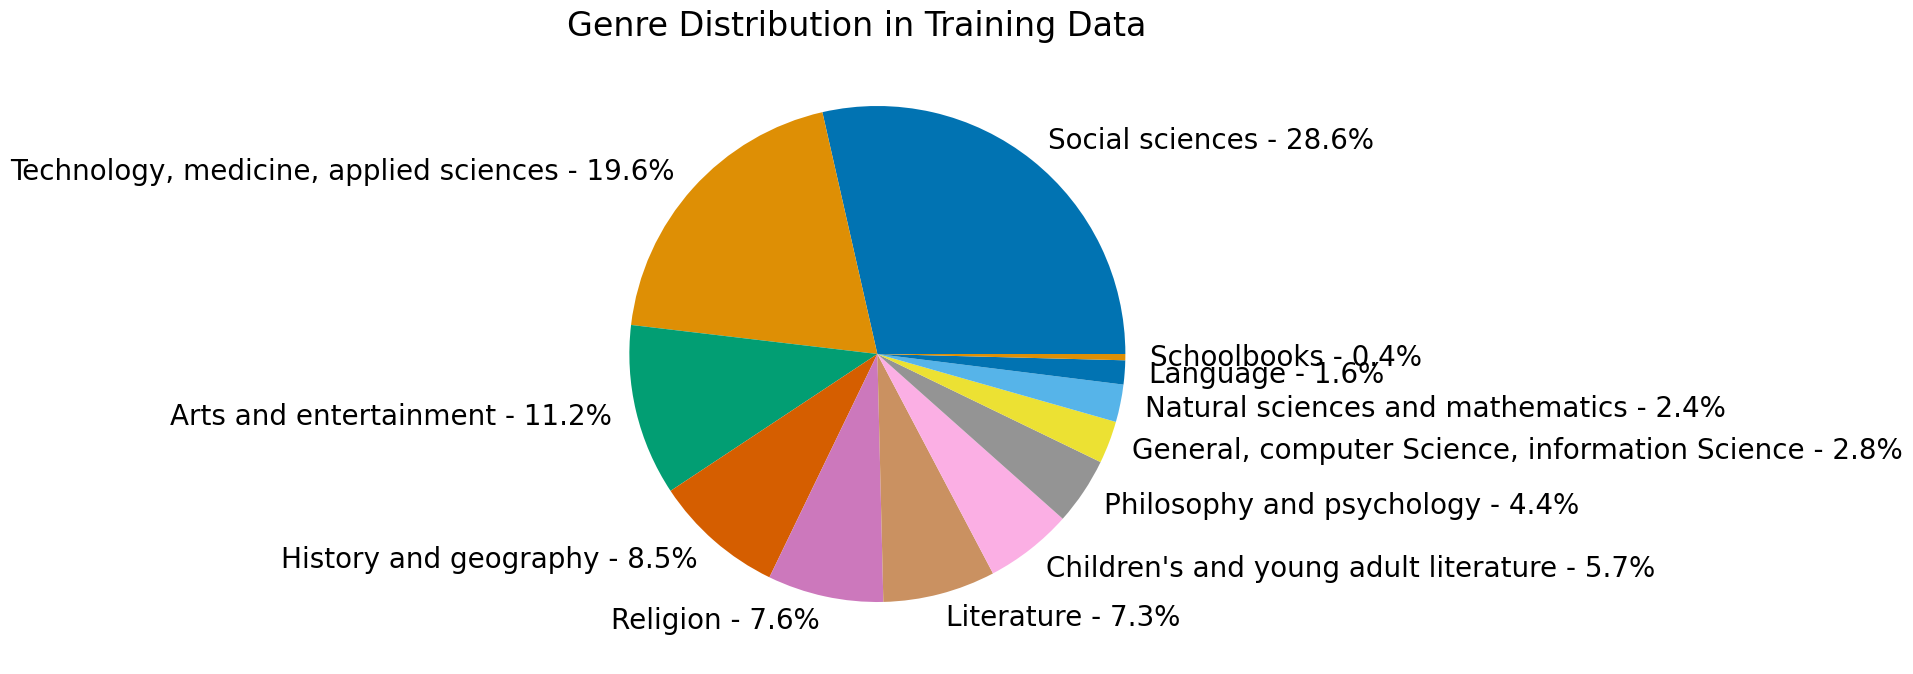

In [61]:
# Pie chart for distribution of genres. 
colors = sns.color_palette('colorblind')
percent = 100.*hsg_counts/hsg_counts.sum()
labels = ['{0} - {1:1.1f}%'.format(i,j) for i,j in zip(hsg_counts.index, percent)]
plt.pie(hsg_counts, labels=labels, colors=colors)
plt.title("Genre Distribution in Training Data", loc="left")
#plt.tight_layout()

name = "genres_dist.jpg"
path_fig = os.path.join(plot_dir, name)
plt.savefig(path_fig, dpi=600, bbox_inches='tight')

### Social Sciences - Fine-Grained Labels

In [71]:
social_translation = {
    'Recht': "Law", 
    'Wirtschaft': "Economy", 
    'Erziehung, Schul- und Bildungswesen': "Upbringing, schooling and education",
    'Sozialwissenschaften, Soziologie, Anthropologie': "Social sciences, sociology, anthropology",
    'Soziale Probleme, Sozialdienst, Versicherungen': "Social issues, social services, insurance", 
    'Politik': "Politics",
    'Handel, Kommunikation, Verkehr': "Trade, communication, transport", 
    'Bräuche, Etikette, Folklore': "Customs, etiquette, folklore",
    'Öffentliche Verwaltung': "Public administration", 
    'Natürliche Ressourcen, Energie und Umwelt': "Natural resources, energy and environment",
    'Militär': "Military", 
    'Allgemeine Statistiken': "General statistics"
}


In [72]:
social_science_code = "3"
docid2hsg, hsg2label = hsg_data(genre_path, shorten_codes=False)

# Add information of genres to data frame.
df_train["hsg-full"] = df_train["doc_idn"].apply(lambda x: docid2hsg.get(x))

df_social = df_train[df_train["hsg"] == social_science_code]

social_counts = df_social["hsg-full"].value_counts()
social_counts.index = list(map(lambda x: hsg2label.get(x), social_counts.index))

social_counts.index = list(map(lambda x: social_translation.get(x), social_counts.index))
social_counts = 100 * social_counts / social_counts.sum()


In [83]:
grouped_social = {"Other": 0}
cut_off = 2
for genre, perc in social_counts.items():
    if perc < cut_off:
        grouped_social["Other"] += perc
    else:
        grouped_social[genre] = perc

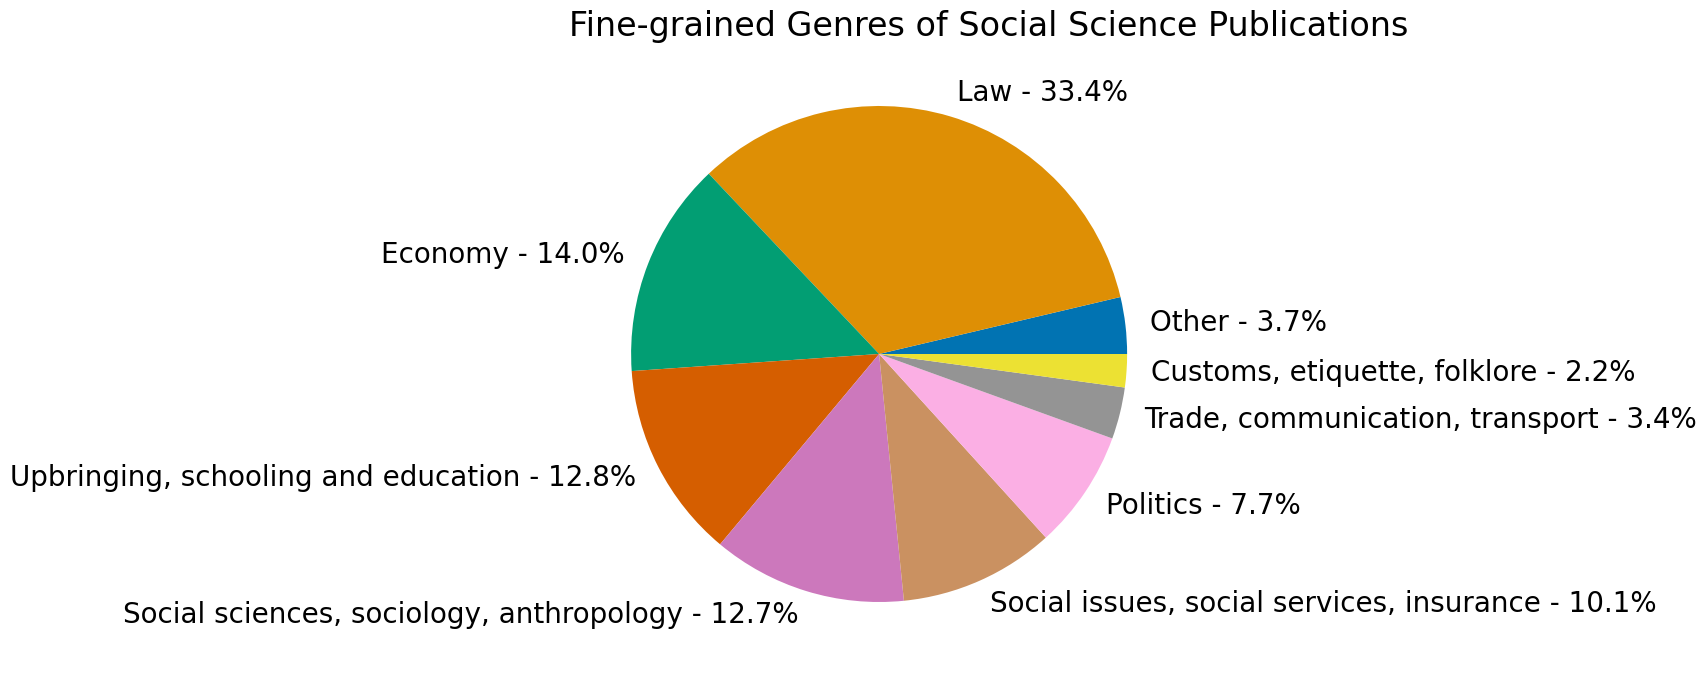

In [84]:

labels = ['{0} - {1:1.1f}%'.format(i,j) for i,j in grouped_social.items()]
plt.pie(grouped_social.values(), colors=colors, labels=labels)
# plt.legend(patches, labels, loc='best', bbox_to_anchor=(1, 0.9), fontsize=9)
plt.title("Fine-grained Genres of Social Science Publications", loc="left")

name = "social_science_dist.jpg"
path_fig = os.path.join(plot_dir, name)
plt.savefig(path_fig, dpi=600, bbox_inches='tight')

## Avg. Number of Labels per Title

In [85]:
train_data = data["train"]
val_data = data["validate"]

In [88]:
avg_labels = [len(labels) for labels in train_data["label-ids"]]
avg_labels = mean(avg_labels)
# Avergae number of GNDs per title
print(f"Average number of GNDs per title: {avg_labels:.2f}")

Average number of GNDs per title: 2.76


## Avg. Word Length

In [89]:
data

{'train': Dataset({
    features: ['title', 'label-ids', 'label-names', 'doc_idn'],
    num_rows: 951104
}), 'validate': Dataset({
    features: ['title', 'label-ids', 'label-names', 'doc_idn'],
    num_rows: 73320
}), 'test': Dataset({
    features: ['title', 'label-ids', 'label-names', 'doc_idn'],
    num_rows: 8415
})}

In [87]:
# Average title length
print(f"Mean: {data['title-length'].mean()}")
print(f"Standard Deviation: {data['title-length'].std()}")
print(f"Median: {data['title-length'].median()}")

KeyError: 'title-length'

Text(0.5, 0, 'Title Length')

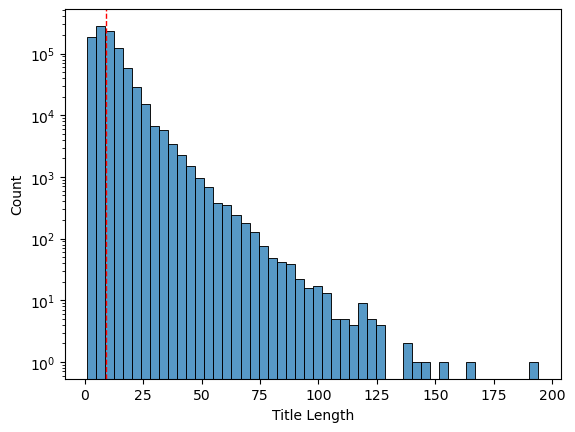

In [15]:
# histogram of title lengths
sns.histplot(data["title-length"], bins=50)
# add median line
plt.axvline(data["title-length"].median(), color='r', linestyle='dashed', linewidth=1)
plt.yscale("log")
plt.xlabel("Title Length")

## Zipf Distribution

In [92]:
freq_labels = {}

for idns in data["train"]["label-ids"]:
    for idn in idns:
        if idn not in freq_labels:
            freq_labels[idn] = 0
        freq_labels[idn] += 1

In [94]:
# find max frequency
max_freq = max(freq_labels, key=freq_labels.get)
max_freq, freq_labels[max_freq]

('040118827', 83121)

In [95]:
freqs = sorted(freq_labels.values(), reverse=True)
rank = range(1, len(freqs) + 1)

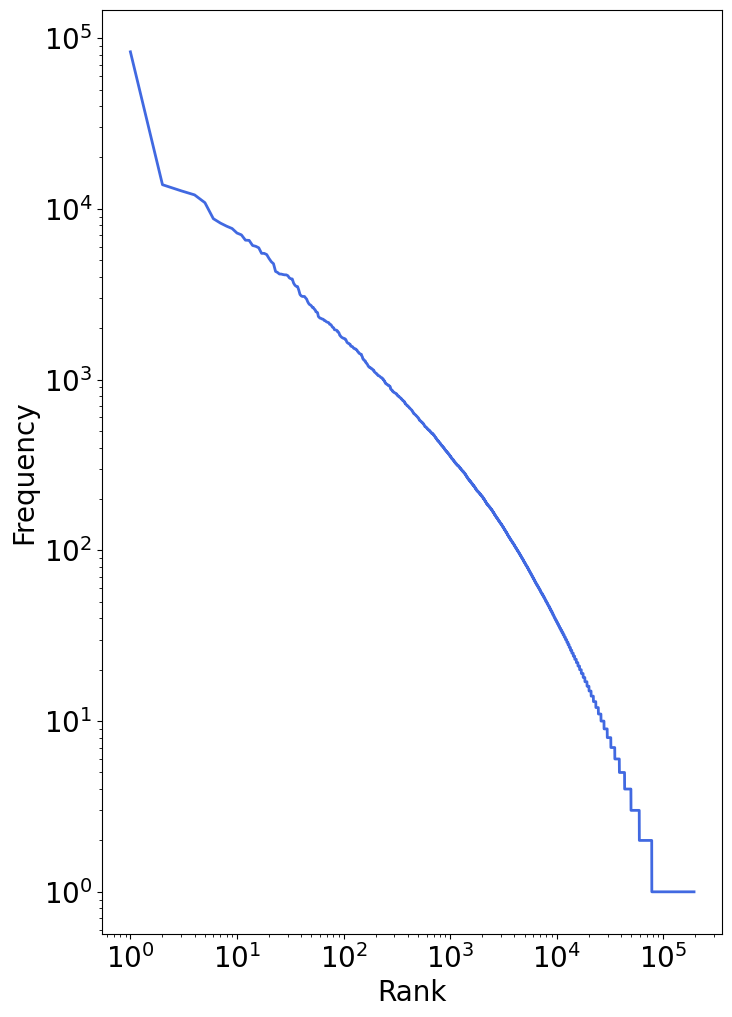

In [96]:
sns.lineplot(x=rank, y=freqs, color='royalblue', lw=2)
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')   

## Avg. Number of title per label

In [97]:
print(f"Mean: {mean(freq_labels.values())}")
print(f"Median: {median(freq_labels.values())}")
print(f"Standard Deviation: {stdev(freq_labels.values())}")

Mean: 13.546918576178571
Median: 1
Standard Deviation: 220.50965092514397


## Token and Types

In [26]:
print(f"Total number of words in titles: {data['title-length'].sum()}")

Total number of words in titles: 9495802


In [27]:
types = set()
for tokens in tqdm(data["tokenized"]):
    for token in tokens:
        types.add(token)

  0%|          | 0/951103 [00:00<?, ?it/s]

100%|██████████| 951103/951103 [00:02<00:00, 469450.65it/s]


In [28]:
print(f"Number of unique words: {len(types)}")

Number of unique words: 705522


# Graph GND

### Label Types

In [98]:
rows = []
for idn, idn_data in gnd.nodes(data=True):
    row = {"idn": idn}
    row.update(idn_data)
    row["pref"] = list(row["pref"])[0]
    rows.append(row)
gnd_df = pd.DataFrame(rows)

In [129]:
ent_mapping = {
    "Sachbegriff": "Topic",
    "Person (individualisiert)": "Person",
    "Körperschaft": "Corporate Body",
    "Geografikum": "Geographic Entity",
    "Werk": "Work",
    "Konferenz": "Conference & Event",
}

[Text(0.5, 0, 'Entity type'), Text(0, 0.5, 'Frequency in GND')]

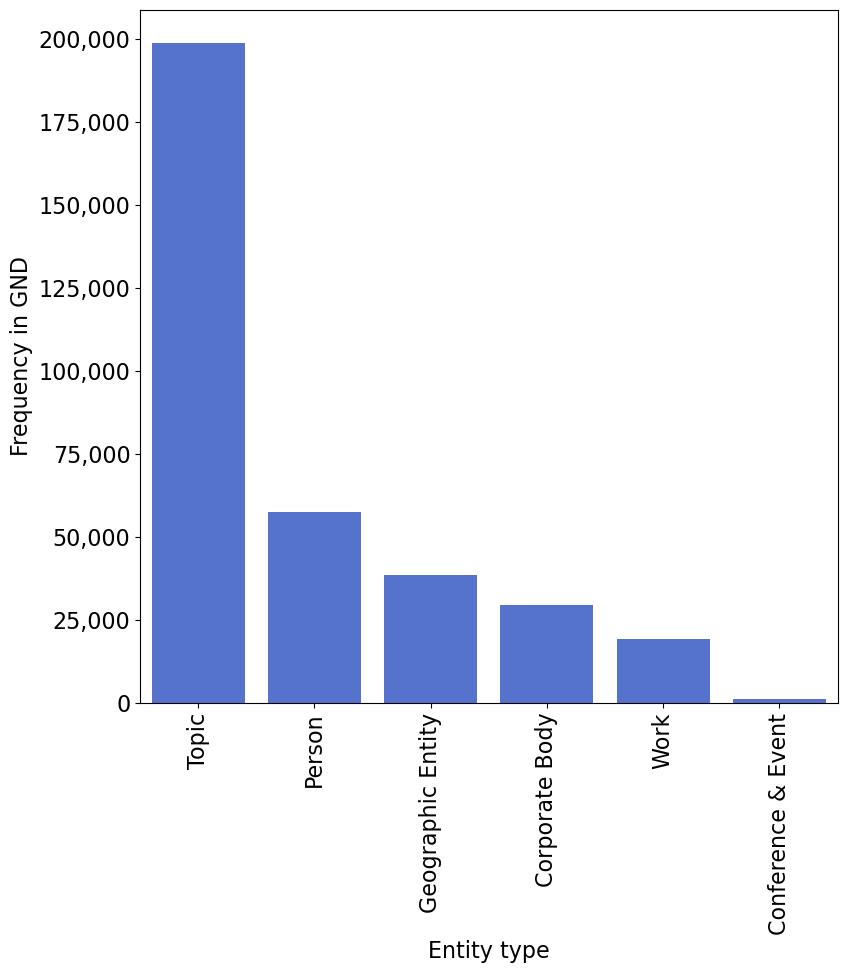

In [130]:
val_counts = dict(gnd_df.value_counts("type"))
names = map(ent_mapping.get, val_counts.keys())
ax = sns.barplot(
    x = list(names),
    y = list(val_counts.values()),
    color='royalblue'
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=90)
ax.set(xlabel='Entity type', ylabel='Frequency in GND')

In [102]:
label_frequency = [freq_labels.get(idn, 0) for idn in gnd_df["idn"]]
gnd_df["label_frequency"] = label_frequency

In [103]:
gnd_df.sort_values("label_frequency", ascending=False).head(10)[["pref", "label_frequency", "type"]]

,pref,label_frequency,type
580,Deutschland,83121,Geografikum
5176,Österreich,13850,Geografikum
965,Deutsch,12749,Sachbegriff
3960,Zeitschrift,12072,Sachbegriff
3686,Schweiz,10870,Geografikum
7872,Erster Weltkrieg,8758,Sachbegriff
3032,Literatur,8250,Sachbegriff
295,Europäische Union,7913,Körperschaft
15492,Kind,7670,Sachbegriff
9285,Frau,7217,Sachbegriff


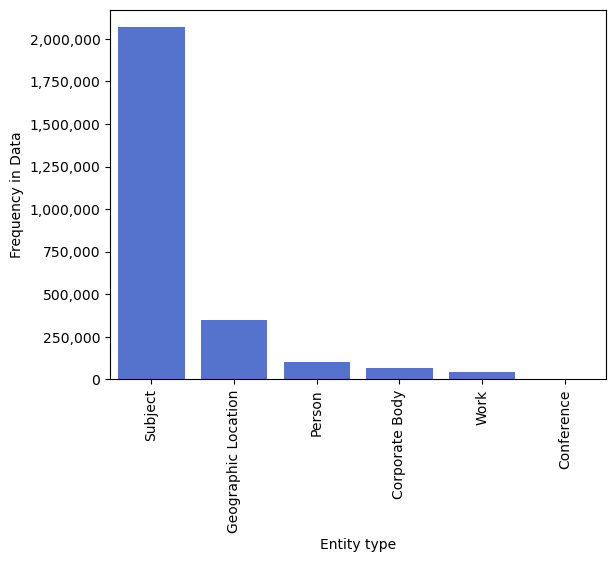

In [84]:
freq_by_type = gnd_df.groupby("type")["label_frequency"].sum()
freq_by_type = freq_by_type.sort_values(ascending=False)
names = list(map(ent_mapping.get, freq_by_type.index))
# plot
ax = sns.barplot(
    x = names,
    y = freq_by_type.values,
    color='royalblue', 
    order=names
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(xlabel='Entity type', ylabel='Frequency in Data')
plt.xticks(rotation=90)
plt.show()

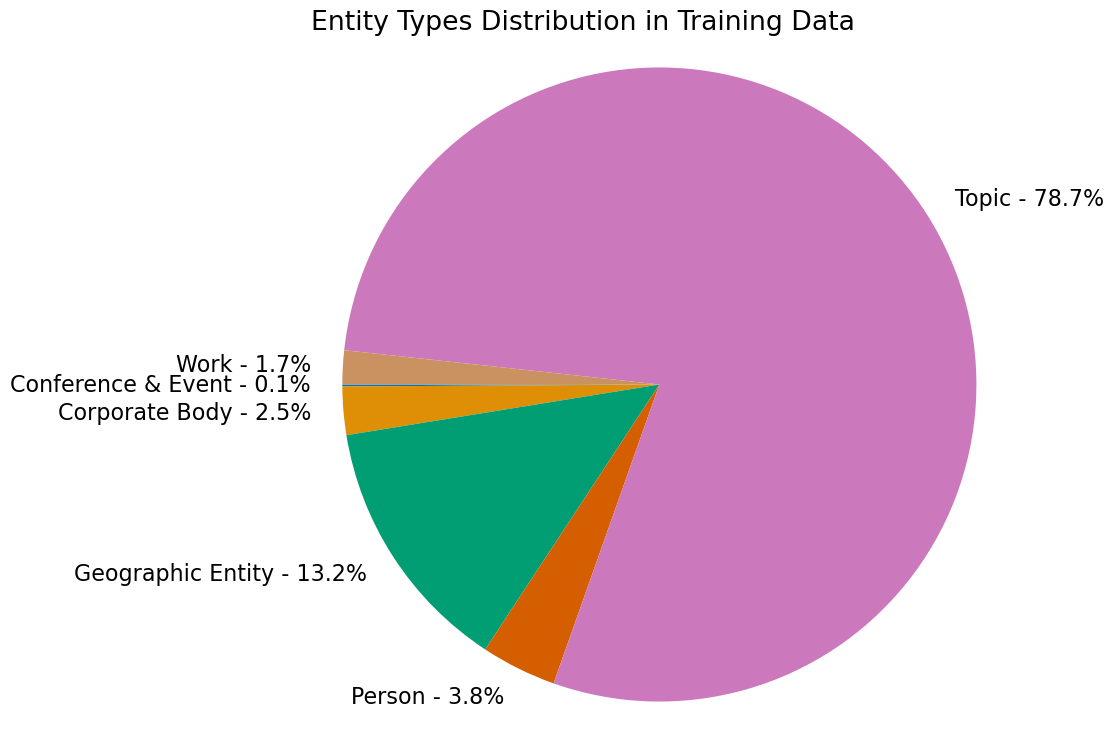

In [131]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [9,9]

freq_data = gnd_df.groupby("type")["label_frequency"].sum()*100 / gnd_df["label_frequency"].sum()
# set index
freq_data.index = list(map(ent_mapping.get, freq_data.index))
freq_data = freq_data.sort_index()
labels = ['{0} - {1:1.1f}%'.format(i,j) for i,j in freq_data.items()]
# pie chart
fig, ax = plt.subplots()
ax.pie(freq_data, labels=labels, startangle=180, colors=colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Entity Types Distribution in Training Data", loc="left")
name = "freq_label_data.jpg"
path_fig = os.path.join(plot_dir, name)
plt.savefig(path_fig, dpi=600, bbox_inches='tight')


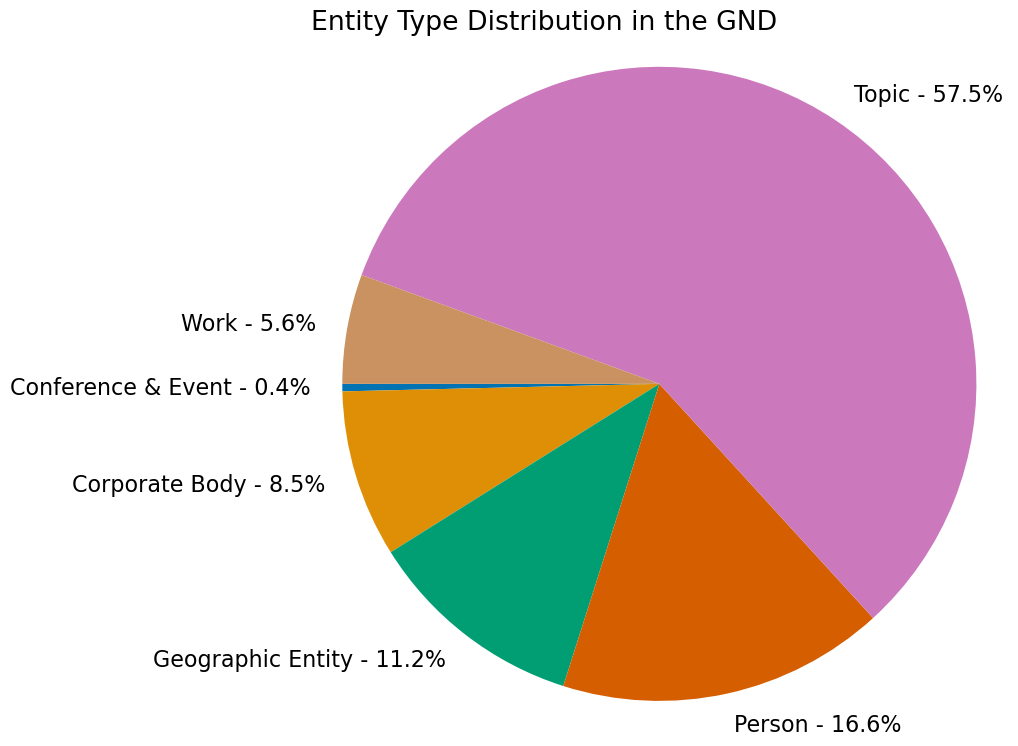

In [132]:
freq_gnd = gnd_df.value_counts("type")*100 / gnd_df.shape[0]
freq_gnd.index = list(map(ent_mapping.get, freq_gnd.index))
# sort by name
freq_gnd = freq_gnd.sort_index()
fig, ax = plt.subplots()
labels = ['{0} - {1:1.1f}%'.format(i,j) for i,j in freq_gnd.items()]
ax.pie(freq_gnd, labels=labels, startangle=180, colors=colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Entity Type Distribution in the GND", loc="left")
name = "freq_label_gnd.jpg"
path_fig = os.path.join(plot_dir, name)
plt.savefig(path_fig, dpi=600, bbox_inches='tight')

## Find Hierarchies


In [202]:
from collections import deque

In [ ]:
for n, node_data in gnd.nodes(data=True):
    q = deque()
    hierarchy = []
    if node_data.get("type") == "Sachbegriff":
        q.append([n])
        while q:
            current_path = q.popleft()
            last_node = current_path[-1]
            neighbors = list(gnd.neighbors(last_node))
            if len(neighbors) == 0:
                hierarchy.append(current_path)
            for ne in neighbors:
                rel_type = gnd.get_edge_data(last_node, ne)["relation"]
                n_type = gnd.nodes[ne].get("type")
                if rel_type == "broader" and n_type == "Sachbegriff":
                    new_path = current_path.copy()
                    new_path.append(ne)
                    q.append(new_path)
        for p in hierarchy:
            print("->".join([list(gnd.nodes[n]["pref"])[0] for n in p]))

# How difficult is our problem?

In [53]:
sent_model = SentenceTransformer(config["sentence_transformer_model"])
tokenizer = sent_model.tokenizer

In [54]:
enc_title = sent_model.encode(val_data["title"], batch_size=256, show_progress_bar=True)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [55]:
label2i_index = {
}
i2label_index = {
}
i = 0
for idns in tqdm(val_data["label-ids"]):
    for idn in idns:
        if idn not in label2i_index:
            label2i_index[idn] = i
            i2label_index[i] = idn
            i += 1

100%|██████████| 2200/2200 [00:00<00:00, 623351.27it/s]


In [56]:
label_strings = list([get_pref_label(gnd, idn) for idn in label2i_index.keys()])
enc_labels = sent_model.encode(
    label_strings,
    batch_size=256,
    show_progress_bar=True
)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [62]:
sims = []
sim_dict = {}
c = 0
for i, (title, l_ids) in tqdm(enumerate(zip(val_data["title"], val_data["label-ids"]))):
    label_name = get_pref_label(gnd, l)
    for l in l_ids:
        label_name = get_pref_label(gnd, l)
        sim = sent_model.similarity(enc_title[i], enc_labels[label2i_index[l]])
        sims.append(sim[0][0])
        sim_dict[(title, label_name)] = sim[0][0]

0it [00:00, ?it/s]

2200it [00:00, 3320.10it/s]


In [73]:
histogram(list(sim_dict.values()), bins=4, range=(0, 1))

(array([ 158, 4451, 2523,  118]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32))

In [74]:
grouped_sim = {
    "not-similar": [],
    "somewhat-similar": [],
    "similar": [],
    "very-similar": [],
}

for (title, label_name), sim in sim_dict.items():
    if sim < 0.25:
        grouped_sim["not-similar"].append((title, label_name, sim))
    elif sim < 0.5:
        grouped_sim["somewhat-similar"].append((title, label_name, sim))
    elif sim < 0.75:
        grouped_sim["similar"].append((title, label_name, sim))
    else:
        grouped_sim["very-similar"].append((title, label_name, sim))

In [75]:
print(f"Not similar: {len(grouped_sim['not-similar'])}")
print(f"Somewhat similar: {len(grouped_sim['somewhat-similar'])}")
print(f"Similar: {len(grouped_sim['similar'])}")
print(f"Very similar: {len(grouped_sim['very-similar'])}")

Not similar: 158
Somewhat similar: 4451
Similar: 2523
Very similar: 124


In [79]:
# Sample some titles and labels from each group
def sample_from_group(group, n=5):
    return random.sample(group, min(n, len(group)))
sampled_groups = {k: sample_from_group(v) for k, v in grouped_sim.items()}
# Print the sampled titles and labels
for group, samples in sampled_groups.items():
    print(f"\n{group.capitalize()}:")
    for title, label_name, sim in samples:
        print(f"Title: {title}, Label: {label_name}, Similarity: {sim:.2f}")


Not-similar:
Title: Die Haller Synagogen des Elieser Sussmann im Kontext der Sammlung des Hällisch-Fränkischen Museums, Label: None, Similarity: 0.23
Title: Glaube an die Ärzte und an die Heilmittel Ansichten und Erfahrungen eines Heilpraktikers, Label: Brunner, Constantin (1862-1937), Similarity: 0.22
Title: Auswirkungen von hohem hydrostatischem Druck auf Schimmelpilze und die Synthese des Mycotoxins Patulin, Label: Konidie, Similarity: 0.19
Title: Luftschlosser ein Blick auf Haus-Rucker-Co/Post-Haus-Rucker, Label: Zamp Kelp, Günter (1941), Similarity: 0.24
Title: Pferde, Freiheit, wildes Land drei Romane in einem Band, Label: Cheyenne (Volk), Similarity: 0.19

Somewhat-similar:
Title: Komfortgewinn für Passagiere auf Langstreckenflügen Validierung chronobiologisch wirksamer Kabinenbeleuchtung zur Jetlag-Reduktion, Label: Flugsimulator, Similarity: 0.44
Title: Die Gute Herstellungspraxis zwischen Sein und Sollen Rechtstheorie und Praxis im Lebensmittelrecht, Label: Sein-Sollen-

In [58]:
sims = [float(sim) for sim in sims]

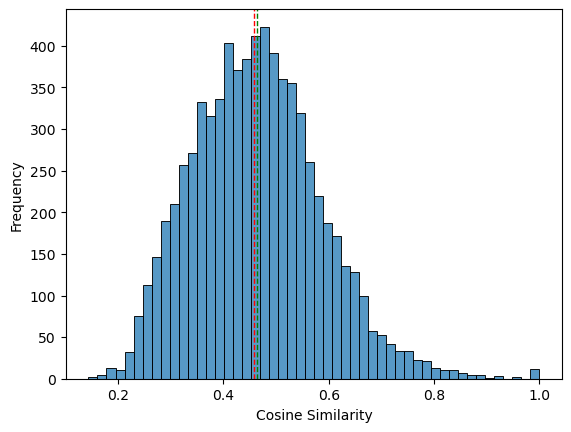

In [59]:
sns.histplot(sims, bins=50)
plt.axvline(mean(sims), color='g', linestyle='dashed', linewidth=1)
plt.axvline(median(sims), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [60]:
import random

In [51]:
# sims_random = []
# for title in tqdm(data.itertuples()):
#     index = title.Index
#     labels = random.sample(range(gnd_df.shape[0]), 2)
#     for l in labels:
#         sim = sent_model.similarity(enc_title[index], enc[l])
#         sims_random.append(sim[0][0])
sims_random = []
c = 0
for i, (title, l_ids) in tqdm(enumerate(zip(val_data["title"], val_data["label-ids"]))):
    labels = random.sample(list(label2i_index.keys()), 3)
    for l in labels:
        sim = sent_model.similarity(enc_title[i], enc_labels[label2i_index[l]])
        sims_random.append(sim[0][0])

0it [00:00, ?it/s]

2200it [00:00, 3222.60it/s]


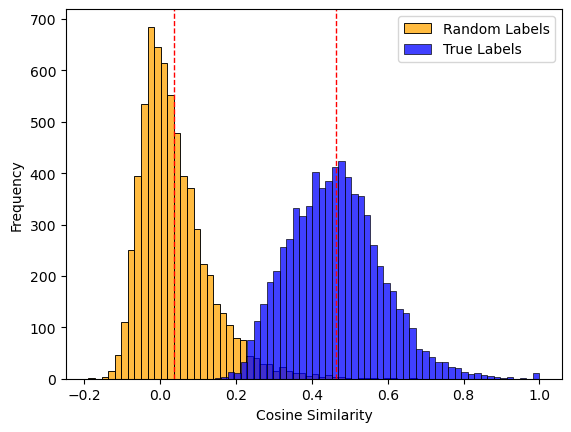

In [61]:
sims_random = [float(sim) for sim in sims_random]
sns.histplot(sims_random, bins=50, color='orange')
sns.histplot(sims, bins=50, color='blue')
plt.legend(["Random Labels", "True Labels"])
plt.axvline(mean(sims_random), color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean(sims), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()